In [1]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd

col = 6

# Import the training set
dataset_train = pd.read_csv('TWII_train.csv')  # 讀取訓練集
training_set = dataset_train.iloc[:, 1:col].values  # 取「Open」欄位值

In [2]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [3]:
X_train = []   #預測點的前 60 天的資料
y_train = []   #預測點
for i in range(60, len(dataset_train)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN

In [4]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], col-1))

In [5]:
# Import the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], col-1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [7]:
# Adding the output layer
regressor.add(Dense(units = col-1))

In [8]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            11200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
__________

In [9]:
# Compiling
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 進行訓練
regressor.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
5148/5148 [==============================] - 23s 4ms/step - loss: 0.0235
Epoch 2/20
5148/5148 [==============================] - 21s 4ms/step - loss: 0.0072
Epoch 3/20
5148/5148 [==============================] - 20s 4ms/step - loss: 0.0058
Epoch 4/20
5148/5148 [==============================] - 20s 4ms/step - loss: 0.0047
Epoch 5/20
5148/5148 [==============================] - 21s 4ms/step - loss: 0.0040
Epoch 6/20
5148/5148 [==============================] - 20s 4ms/step - loss: 0.0036
Epoch 7/20
5148/5148 [==============================] - 21s 4ms/step - loss: 0.0030
Epoch 8/20
5148/5148 [==============================] - 21s 4ms/step - loss: 0.0029
Epoch 9/20
5148/5148 [==============================] - 21s 4ms/step - loss: 0.0026
Epoch 10/20
5148/5148 [==============================] - 21s 4ms/step - loss: 0.0023
Epoch 11/20
5148/5148 [==============================] - 21s 4ms/step - loss: 0.0021
Epoch 12/20
5148/5148 [==============================] - 21s 4ms/step - lo

In [10]:
dataset_test = pd.read_csv('TWII_test.csv')
real_stock_price = dataset_test.iloc[:, 1:col].values

In [11]:
dataset_test = dataset_test.iloc[:, 1:col]

In [12]:
dataset_train = dataset_train.iloc[:, 1:col]

In [13]:
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,col-1)
inputs = sc.transform(inputs) # Feature Scaling

X_test = []
for i in range(60, 60+len(dataset_test)):  # timesteps一樣60； 80 = 先前的60天資料+2017年的20天資料
    X_test.append(inputs[i-60:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], col-1))  # Reshape 成 3-dimension

In [14]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)  # to get the original scale

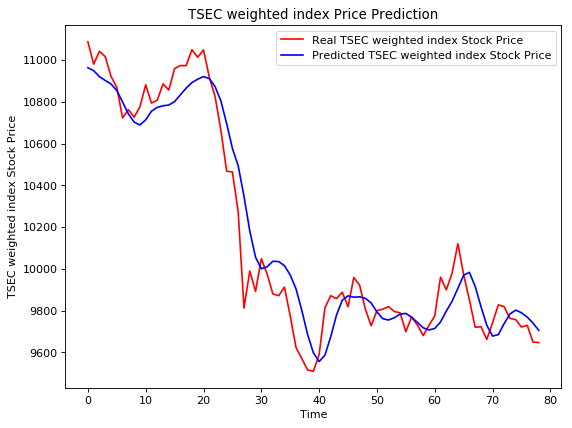

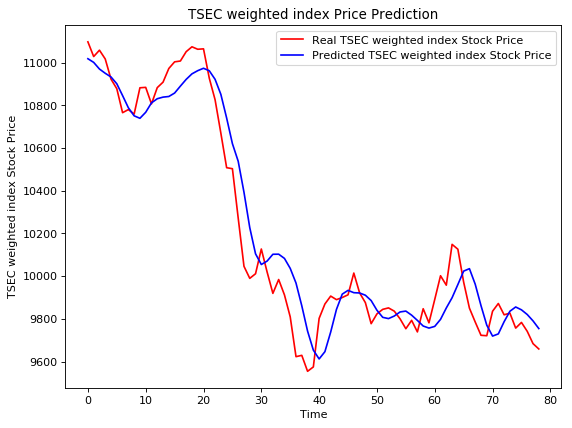

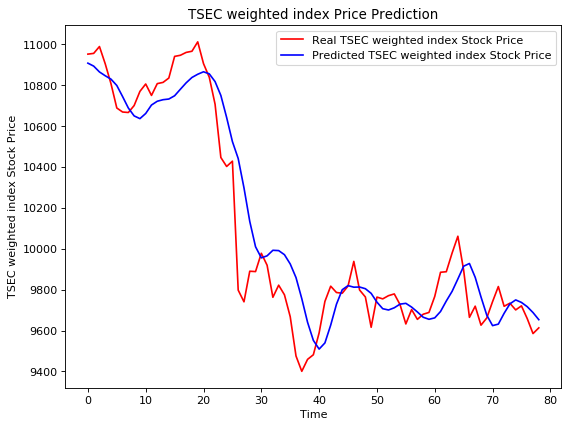

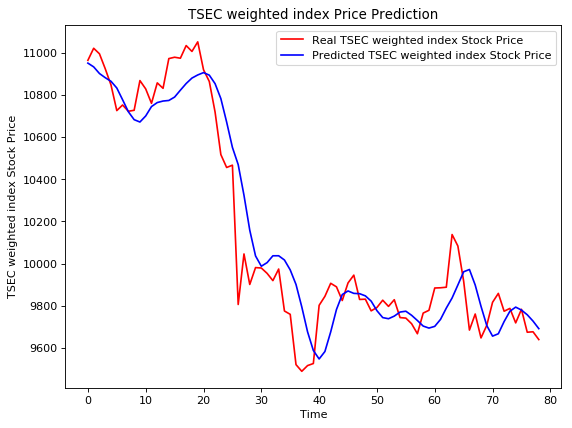

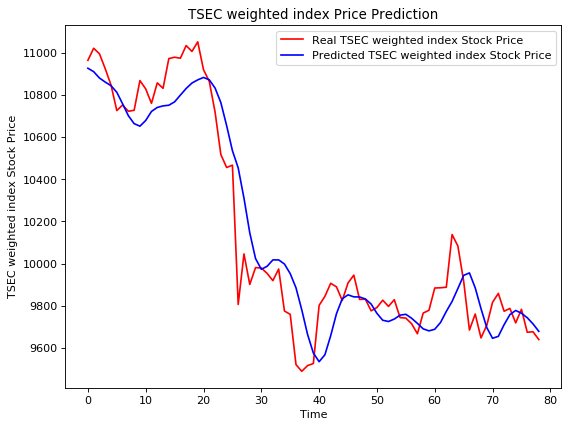

In [17]:
# Visualising the results
from matplotlib.pyplot import figure
for pic in range(0,col-1):
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(real_stock_price[:,pic], color = 'red', label = 'Real TSEC weighted index Stock Price')  # 紅線表示真實股價
    plt.plot(predicted_stock_price[:,pic], color = 'blue', label = 'Predicted TSEC weighted index Stock Price')  # 藍線表示預測股價
    plt.title('TSEC weighted index Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('TSEC weighted index Stock Price')
    plt.legend(loc='upper right')
    plt.show()